### **1. Setup**

This section will set up the environment for running the experiments.

Run the cell below to install PyG.

In [ ]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 80.4 MB/s eta 0:00:00


Run the cell below to download the dataset and the helper functions.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Stock_Prediction_MLG

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1Z3jGmwYTELsHX0bxnBqvh7KRL4pLbII_/Stock_Prediction_MLG


Run the cell below to import relevant packages.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch_geometric.nn import GCNConv, SAGEConv
from torch_geometric.nn.conv import RGCNConv, FastRGCNConv
import torch_geometric.transforms as T
import numpy as np

from utils import *

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### **2. RTGCN with Different GNN Layers**

In this section, we experiment with incorporating two different types of GNN layers (GCN and GraphSage) into the RTGCN framework.

The class below leverages the **PyG GCNConv** class to implement the GCN layers for RTGCN.

Each GNN layer (except the last) comprises a GCNConv layer, 1D Batch norm, ReLU activation and dropout.

In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers,
                 dropout, num_nodes):
        super(GCN, self).__init__()

        # First layer of GCN
        lst_GCNConv = [GCNConv(in_channels = input_dim, out_channels = hidden_dim)]
        # Hidden layers of GCN
        for i in range(num_layers - 2):
          lst_GCNConv.append(GCNConv(in_channels = hidden_dim, out_channels = hidden_dim))
        # Final layer of GCN
        lst_GCNConv.append(GCNConv(in_channels = hidden_dim, out_channels = output_dim))

        self.convs = torch.nn.ModuleList(lst_GCNConv)
        # normalization
        self.bns = torch.nn.ModuleList([torch.nn.BatchNorm1d(num_features = hidden_dim * num_nodes, affine = False) for i in range(num_layers - 1)])
        # dropout to alleviate overfitting
        self.dropout = dropout

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()
        for bn in self.bns:
            bn.reset_parameters()

    def forward(self, x, adj_t):
        for i in range(len(self.convs) - 1):
          x = self.convs[i].forward(x, adj_t)   # graph convolution
          N,T,V,C =  x.size()   # N: batch size, T: timestep, V: number of nodes, C: number of features
          x = torch.permute(x, (0,2,3,1))
          x = x.view(N, V * C, T)
          x = self.bns[i](x)   # normalization
          x = torch.nn.functional.relu(x)   # activation
          x = torch.nn.functional.dropout(x,self.dropout)   # dropout
          x = x.view(N, V, C, T)
          x = x.permute(0, 3, 1, 2).contiguous()

        out = self.convs[-1].forward(x, adj_t)
        return out

In [ ]:
class RTConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, dropout=0, num_nodes=171):
        super().__init__()

        assert len(kernel_size) == 2
        assert kernel_size[0] % 2 == 1
        padding = ((kernel_size[0] - 1) // 2, 0)

        #######################################################
        # Change different GNN layers here:

        # Single layer GCN
        #self.gcn = GCNConv(-1, out_channels)

        # Multi layers GCN (3 layers)
        self.gcn = GCN(-1, int(out_channels*1.5), out_channels, 3, 0.5, num_nodes)
        #######################################################

        # Temporal convolution
        self.tcn = nn.Sequential(
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, (kernel_size[0], 1), (stride, 1), padding),
            nn.BatchNorm2d(out_channels),
            nn.Dropout(dropout, inplace=True),
        )

        self.residual = nn.Sequential(
            nn.Conv2d(in_channels, out_channels,kernel_size=1, stride=(stride, 1)),
            nn.BatchNorm2d(out_channels),
        )

        self.relu = nn.LeakyReLU(inplace=True,negative_slope=0.2)

    def forward(self, x, A):
        res = self.residual(x) # for processing the residual component
        x = x.permute(0,2,3,1)
        # relational graph convolution
        x = self.gcn(x, A[0].to_sparse().indices())
        x = x.permute(0,3,1,2)
        # temporal convolution and residual connection
        x = self.tcn(x) + res

        return self.relu(x), A

The class below defines the overall **RTGCN model**. It constructs different components of the model, processes the graph, normalizes the data, and passes the inputs through the components.

In [ ]:
class RTGCN(nn.Module):
    def __init__(self, in_channels, market, relation_path):
        super().__init__()

        # load graph
        self.graph = Graph(market=market, relation_path=relation_path)
        A = torch.tensor(self.graph.A, dtype=torch.float32, requires_grad=False)
        relation = torch.tensor(self.graph.relation, dtype=torch.float32, requires_grad=False)
        self.register_buffer('A', A)
        self.register_buffer('relation', relation)

        # build networks
        spatial_kernel_size = A.size(0)
        temporal_kernel_size = 9
        kernel_size = (temporal_kernel_size, spatial_kernel_size)
        self.data_bn = nn.BatchNorm1d(in_channels * A.size(1))

        self.linear = nn.Linear(self.relation.size(2),1)
        self.rt_gcn_networks = nn.ModuleList((RTConv(in_channels, 8, kernel_size, 2),))

        # initialize parameters for edge importance weighting with "weighted" strategy
        self.edge_importance = nn.ModuleList([nn.Linear(self.relation.size(2),1) for i in self.rt_gcn_networks])

        # fcn for prediction
        self.fcn = nn.Conv2d(8, 1, kernel_size=1)

    def forward(self, x):
        # data normalization
        N, C, T, V = x.size()   # N: batch size, T: timestep, V: number of nodes, C: number of features
        x = x.permute(0, 3, 1, 2).contiguous()
        x = x.view(N, V * C, T)
        x = self.data_bn(x)
        x = x.view(N, V, C, T)
        x = x.permute(0, 2, 3, 1).contiguous()
        x = x.view(N, C, T, V)

        # relational-temporal graph convolution
        S, M, D = self.relation.size()
        for gcn, importance in zip(self.rt_gcn_networks, self.edge_importance):
            x, _ = gcn(x, self.A * (importance(self.relation.view(S*M, D)).view(S,M)+torch.eye(S).to(device)))

        # global pooling
        x = F.avg_pool2d(x,(x.size(2),1))
        x = x.view(N,-1,1,V)

        # prediction
        x = self.fcn(x)
        x = x.view(x.size(0), x.size(3))

        return x


The macro variables and hyperparameters are defined below.

In [ ]:
market = "NIFTY"
relation_path = "NIFTY_relations.npy"
train_data_path = "train_15_eod.npy"
train_price_path = "train_15_price.npy"
train_label_path = "train_15_label.pkl"
test_data_path = "test_15_eod.npy"
test_price_path = "test_15_price.npy"
test_label_path = "test_15_label.pkl"

# hyperparameters
n_epochs = 50
batch_size = 64
in_channels = 4
dropout = 0.5
lr = 0.001
weight_decay = 0.1

# use cuda when available, otherwise modify to 'cpu'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Initialize the model, loss function, and optimizer below.

In [ ]:
model = RTGCN(in_channels, market, relation_path)
model = model.to(device)
loss_func = nn.MSELoss()   # use simple MSE loss
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

Load the data.

In [ ]:
data_loader = dict()
data_loader['train'] = torch.utils.data.DataLoader(
        dataset=Feeder(train_data_path, train_price_path, train_label_path),
        batch_size=batch_size,
        shuffle=True,
        drop_last=True)
data_loader['test'] = torch.utils.data.DataLoader(
        dataset=Feeder(test_data_path, test_price_path, test_label_path),
        batch_size=batch_size,
        shuffle=False)

Define training procedure.

In [ ]:
def train():
    model.train()

    loader = data_loader['train']
    loss_value = []
    for data, closing_price, label in loader:

        data = data[:,[0,1,2,4],:,:].float().to(device)
        closing_price = closing_price.float().to(device)
        label = label.float().to(device)
        # forward
        output = model(data)
        prediction = torch.div(torch.sub(output, closing_price), closing_price)
        loss = loss_func(prediction, label)

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # statistics
        loss_value.append(loss.data.item())

    return np.mean(loss_value)

Define testing procedure.

In [ ]:
def test(evaluation=True):
    model.eval()
    loader = data_loader['test']
    loss_value = []
    result_frag = []
    label_frag = []
    irr_rankings = []   # <-- for storing the 2×171 structure

    for data, closing_price, label in loader:

        # get data
        data = data[:, [0,1,2,4], :, :].float().to(device)
        closing_price = closing_price.float().to(device)
        label = label.float().to(device)

        with torch.no_grad():
            output = model(data)
            prediction = (output - closing_price) / closing_price

        result_frag.append(prediction.data.cpu().numpy())

        if evaluation:
            loss = loss_func(prediction, label)
            loss_value.append(loss.item())
            label_frag.append(label.data.cpu().numpy())

    result = np.concatenate(result_frag)

    if evaluation:
        label = np.concatenate(label_frag)

        # Delete problematic sample index 89
        result = np.delete(result, 89, axis=0)
        label   = np.delete(label, 89, axis=0)

        # ---------- MAE ----------
        mae = np.mean([np.mean(np.abs(result[i] - label[i])) for i in range(result.shape[0])])

        # ---------- IRR rankings ----------
        for i in range(result.shape[0]):
            pred_i = result[i]

            # top-5 IRR
            top5_idx = np.argsort(pred_i)[-5:][::-1]
            top5_list = [(int(idx), float(pred_i[idx])) for idx in top5_idx]

            # top-10 IRR
            top10_idx = np.argsort(pred_i)[-10:][::-1]
            top10_list = [(int(idx), float(pred_i[idx])) for idx in top10_idx]

            irr_rankings.append([top5_list, top10_list])

        # ---------- Return-ratio metrics ----------
        top5_irr = calc_return_ratio(result, label, 5)
        top10_irr = calc_return_ratio(result, label, 10)

        print("MAE:", mae, "Top-5 return ratio:", top5_irr, "Top-10 return ratio:", top10_irr)

        # return everything needed
        return mae, top5_irr, top10_irr, irr_rankings, loss_value

    else:
        return result

In [ ]:
'''
def test(evaluation=True):
    model.eval()
    loader = data_loader['test']
    loss_value = []
    result_frag = []
    label_frag = []

    for data, closing_price, label in loader:
        # get data
        data = data[:,[0,1,2,4],:,:].float().to(device)
        closing_price = closing_price.float().to(device)
        label = label.float().to(device)
        # inference
        with torch.no_grad():
            output = model(data)
            prediction = torch.div(torch.sub(output, closing_price), closing_price)
        result_frag.append(prediction.data.cpu().numpy())
        # get loss
        if evaluation:
            loss = loss_func(prediction, label)
            loss_value.append(loss.item())
            label_frag.append(label.data.cpu().numpy())

    result = np.concatenate(result_frag)
    if evaluation:
        label = np.concatenate(label_frag)
        result = np.delete(result,89, axis=0)
        label = np.delete(label,89, axis=0)
        mae = 0.0
        for i in range(result.shape[0]):
            mae += np.sum(np.absolute(result[i]-label[i]))/len(result[i])
        epoch_mae = mae / result.shape[0]
        epoch_mean_loss = np.mean(loss_value)
        top5_irr = calc_return_ratio(result, label, 5)
        top10_irr = calc_return_ratio(result, label, 10)
        print("MAE:", epoch_mae, "Top-5 return ratio:", top5_irr, "Top-10 return ratio:", top10_irr)
        '''

'\ndef test(evaluation=True):\n    model.eval()\n    loader = data_loader[\'test\']\n    loss_value = []\n    result_frag = []\n    label_frag = []\n\n    for data, closing_price, label in loader:\n        # get data\n        data = data[:,[0,1,2,4],:,:].float().to(device)\n        closing_price = closing_price.float().to(device)\n        label = label.float().to(device)\n        # inference\n        with torch.no_grad():\n            output = model(data)\n            prediction = torch.div(torch.sub(output, closing_price), closing_price)\n        result_frag.append(prediction.data.cpu().numpy())\n        # get loss\n        if evaluation:\n            loss = loss_func(prediction, label)\n            loss_value.append(loss.item())\n            label_frag.append(label.data.cpu().numpy())\n\n    result = np.concatenate(result_frag)\n    if evaluation:\n        label = np.concatenate(label_frag)\n        result = np.delete(result,89, axis=0)\n        label = np.delete(label,89, axis=0)\n 

Start training below!

In [ ]:
best_loss = 1e9
for epoch in range(n_epochs):
    # training
    epoch_loss = train()
    print("Epoch:", epoch, "Loss:", epoch_loss)

    # evaluation
    if ((epoch + 1) % 3 == 0) or (epoch + 1 == n_epochs):
        print('Eval epoch: {}'.format(epoch))
        test()

Epoch: 0 Loss: 1.5543626735084934
Epoch: 1 Loss: 0.9920048964651007
Epoch: 2 Loss: 0.7572511183588129
Eval epoch: 2
MAE: 0.7970074 Top-5 return ratio: 1.2199254 Top-10 return ratio: 1.2862395
Epoch: 3 Loss: 0.5939758012169286
Epoch: 4 Loss: 0.5079747250205592
Epoch: 5 Loss: 0.43894864383496734
Eval epoch: 5
MAE: 0.4515106 Top-5 return ratio: 1.4213711 Top-10 return ratio: 1.3478653
Epoch: 6 Loss: 0.3863415357313658
Epoch: 7 Loss: 0.3534619321948604
Epoch: 8 Loss: 0.3319389553446519
Eval epoch: 8
MAE: 0.2724 Top-5 return ratio: 1.2271202 Top-10 return ratio: 1.2462299
Epoch: 9 Loss: 0.31316172135503667
Epoch: 10 Loss: 0.2970147540694789
Epoch: 11 Loss: 0.2834157363364571
Eval epoch: 11
MAE: 0.22409838 Top-5 return ratio: 1.4149219 Top-10 return ratio: 1.3847994
Epoch: 12 Loss: 0.2751872994397816
Epoch: 13 Loss: 0.265207472600435
Epoch: 14 Loss: 0.24759578234270999
Eval epoch: 14
MAE: 0.22211297 Top-5 return ratio: 1.340747 Top-10 return ratio: 1.3540455
Epoch: 15 Loss: 0.239176946251015

In [ ]:
mae, top5, top10, irr_rankings, loss_curve = test()

MAE: 0.10356784 Top-5 return ratio: 1.6438084 Top-10 return ratio: 1.5873724


In [ ]:
import pickle
with open("test_15_label.pkl", "rb") as f:
    actual_prices = pickle.load(f)   # shape: (num_days, num_stocks)
    actual_prices = np.array(actual_prices)

In [ ]:
def compute_actual_irr(price_matrix):
    price_matrix = np.array(price_matrix)
    return (price_matrix[1:] - price_matrix[:-1]) / price_matrix[:-1]


In [ ]:
actual_irr = compute_actual_irr(actual_prices)


/tmp/ipython-input-1823546613.py:3: RuntimeWarning: divide by zero encountered in divide
  return (price_matrix[1:] - price_matrix[:-1]) / price_matrix[:-1]
/tmp/ipython-input-1823546613.py:3: RuntimeWarning: invalid value encountered in divide
  return (price_matrix[1:] - price_matrix[:-1]) / price_matrix[:-1]


In [ ]:
def count_actual_top5(actual_irr):
    num_days, num_stocks = actual_irr.shape
    counts = np.zeros(num_stocks, dtype=int)

    for t in range(num_days):
        irr_t = actual_irr[t]
        top5_idx = np.argsort(irr_t)[-5:][::-1]   # highest 5
        for idx in top5_idx:
            counts[idx] += 1

    return counts


In [ ]:
actual_top5_counts = count_actual_top5(actual_irr)


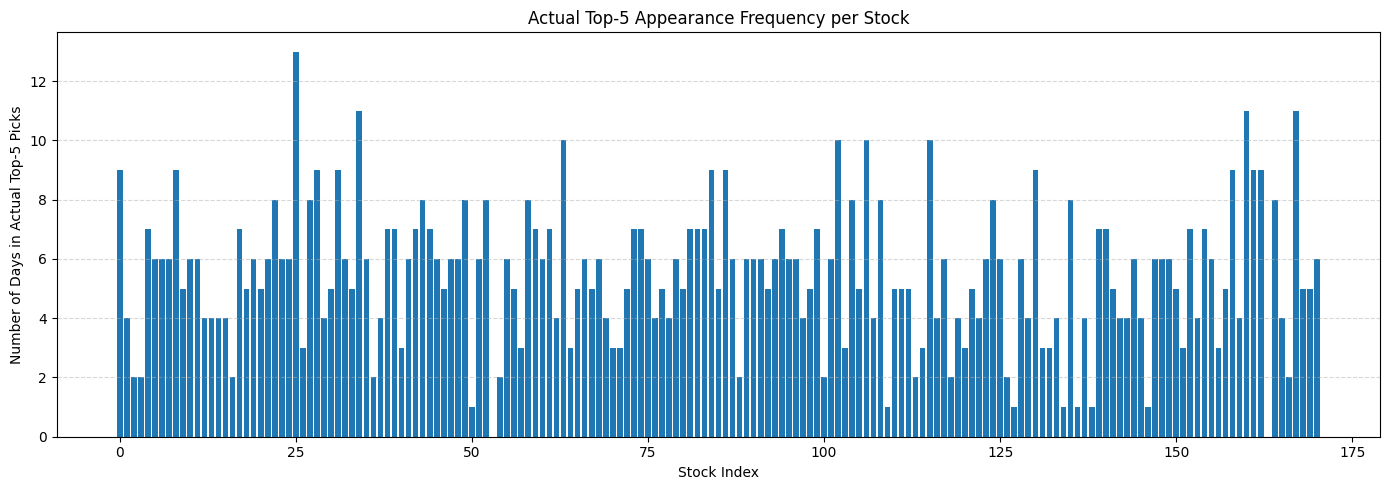

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,5))
plt.bar(range(len(actual_top5_counts)), actual_top5_counts)
plt.xlabel("Stock Index")
plt.ylabel("Number of Days in Actual Top-5 Picks")
plt.title("Actual Top-5 Appearance Frequency per Stock")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [ ]:
irr_rankings[0][0]


[(100, 0.5820951461791992),
 (60, 0.5393800735473633),
 (112, 0.4302051365375519),
 (107, 0.38434168696403503),
 (2, 0.3476518392562866)]

In [ ]:
import numpy as np

def count_top5_appearances(irr_rankings, num_stocks=170):
    counts = np.zeros(num_stocks, dtype=int)

    for day in irr_rankings:
        top5_list = day[0]   # [(stock_idx, irr), ...]
        for stock_idx, irr in top5_list:
            counts[stock_idx] += 1

    return counts


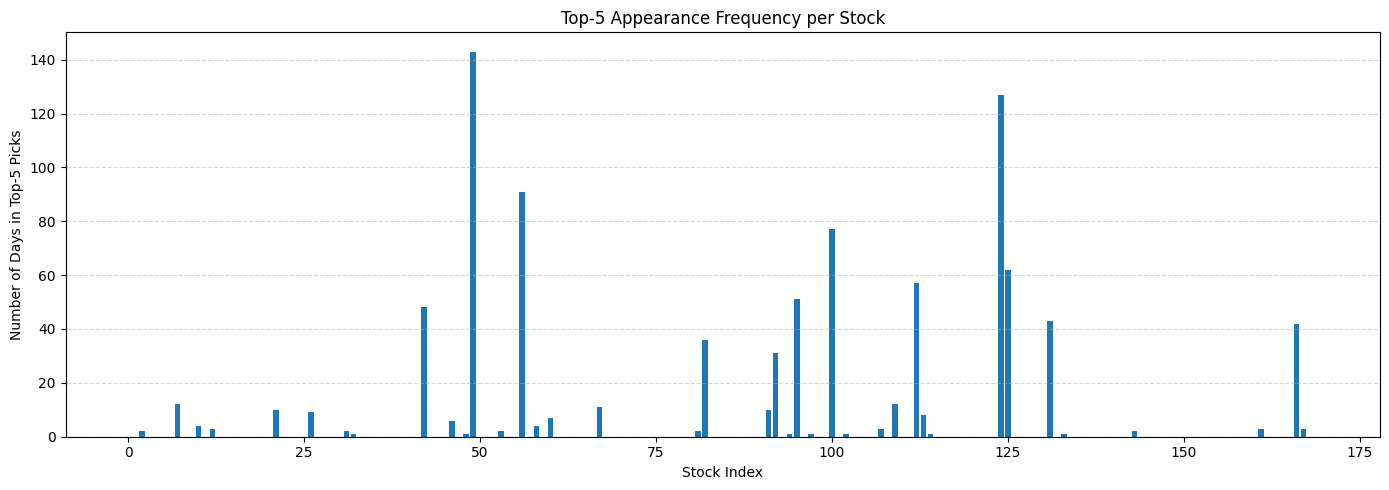

In [ ]:
import matplotlib.pyplot as plt

counts = count_top5_appearances(irr_rankings, num_stocks=170)

plt.figure(figsize=(14, 5))
plt.bar(range(len(counts)), counts)
plt.xlabel("Stock Index")
plt.ylabel("Number of Days in Top-5 Picks")
plt.title("Top-5 Appearance Frequency per Stock")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [ ]:

G = nx.Graph()
edge_lst = []

graph = Graph(market=market, relation_path=relation_path)
relation = torch.tensor(graph.relation, dtype=torch.float32, requires_grad=False)
num_relations = relation.shape[2]

for r in range(num_relations):
    lst = []

    # get COO indices
    indices = relation[:, :, r].to_sparse().indices()   # shape = (2, N)
    rows = indices[0].tolist()
    cols = indices[1].tolist()

    # iterate over edges
    for u, v in zip(rows, cols):
        if u == v:       # skip self-loops
            continue

        G.add_edge(u, v, color='r')
        lst.append((u, v))

    edge_lst.append(lst)

pos = nx.kamada_kawai_layout(G)
#pos = nx.circular_layout(G)

#nx.draw_networkx_edges(G, pos, edgelist=edge_lst[0], edge_color = 'tab:blue')

color = ['red', 'blue']
i = 0
for lst in edge_lst:
    nx.draw_networkx_edges(G, pos, edgelist=lst, edge_color = color[i])
    i = i+1

'''
pos = nx.arf_layout(G)
count = 0
for lst in edge_lst:
  nx.draw_networkx_edges(G, pos, edgelist = lst, edge_color = (random.random(), random.random(), random.random()))
'''
nx.draw_networkx_nodes(G, pos, node_color = 'black', node_size = 10)